
# Plan du Projet:

1. Préparation des données

2. Analyse exploratoire (univariée et bivariée)

3. ACP (Variables quantitatives)

4. ACM (Variables qualitatives)

5. Classification (CAH + K-means)

6. Interprétation globale

# Étape 1 : Préparation des Données

**Objectif** : Importer, nettoyer, et sous-échantillonner le dataset.

In [2]:
import pandas as pd
import numpy as np

# 1. Chargement des données
df = pd.read_excel("Agence.xls")

# 2. Vérification des données manquantes
missing = df.isnull().sum()
print("Données manquantes par colonne:\n", missing)

# 3. Sous-échantillonnage aléatoire (500 lignes)
np.random.seed(42)  # Pour la reproductibilité
sample_df = df.sample(n=500, replace=False)

# 4. Sauvegarde de l'échantillon (optionnel)
sample_df.to_csv("sample_agence.csv", index=False)

Données manquantes par colonne:
 Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
dtype: 

Nous avons chargé le dataset original de 25 976 lignes et effectué un sous-échantillonnage aléatoire de 500 individus pour respecter les contraintes du projet.

In [3]:
# Exclure les colonnes non utiles pour l'analyse (comme 'id' et 'Unnamed')
sample_df = sample_df.drop(columns=['Unnamed: 0', 'id'])

Ces colonnes ne contiennent pas d’informations utiles pour l’analyse (identifiants techniques ou doublons).

In [4]:
# Supprimer les lignes avec des données manquantes dans 'Arrival Delay in Minutes'
sample_df_clean = sample_df.dropna(subset=['Arrival Delay in Minutes'])
print("Données manquantes avant traitement:\n", sample_df.isnull().sum())
print("Données manquantes après traitement:\n", sample_df_clean.isnull().sum())

Données manquantes avant traitement:
 Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             3
dtype: int64
Données manquantes après traitement:
 Gender                               0
Customer Type 

Après suppression des colonnes techniques (Unnamed: 0 et id), les 3 valeurs manquantes dans Arrival Delay in Minutes ont été traitées par suppression (car 3/500 = 0.6% des données, impact négligeable) Le dataset final contient 497/500 observations et 22 variables.

# Étape 2 : Analyse Exploratoire

**Objectif** : Décrire les variables et détecter des tendances.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des variables quantitatives
quant_vars = [
    'Age', 'Flight Distance', 'Departure Delay in Minutes',
    'Arrival Delay in Minutes', 'Inflight wifi service',
    'Food and drink', 'Seat comfort', 'Cleanliness'
]

# Statistiques descriptives détaillées
desc_stats = sample_df_clean[quant_vars].describe(percentiles=[0.25, 0.5, 0.75, 0.95])
print("Statistiques descriptives :\n", desc_stats)

Statistiques descriptives :
               Age  Flight Distance  Departure Delay in Minutes  \
count  497.000000       497.000000                  497.000000   
mean    40.008048      1160.802817                   12.567404   
std     14.471048       966.288957                   28.767701   
min      7.000000        67.000000                    0.000000   
25%     28.000000       436.000000                    0.000000   
50%     41.000000       793.000000                    0.000000   
75%     50.000000      1657.000000                   12.000000   
95%     64.000000      3332.200000                   64.200000   
max     78.000000      3990.000000                  211.000000   

       Arrival Delay in Minutes  Inflight wifi service  Food and drink  \
count                497.000000             497.000000      497.000000   
mean                  12.774648               2.718310        3.273642   
std                   29.041918               1.314132        1.314302   
min           

## Interprétation des Statistiques Descriptives

---

### 1. Âge (Age)

| Moyenne | Médiane | Étendue     | Intervalle interquartile |
|---------|---------|-------------|---------------------------|
| 40 ans  | 41 ans  | 7 – 78 ans  | 28 – 50 ans               |

---

### 2. Distance de Vol (Flight Distance)

| Médiane | Écart-type | Intervalle interquartile | Valeurs extrêmes     |
|---------|------------|---------------------------|----------------------|
| 793 km  | 966 km     | 436 – 1 657 km            | 67 – 3 990 km        |

---

### 3. Retards (Departure / Arrival Delay)

| Type de Retard | Médiane | 75e percentile | Maximum observé     |
|----------------|---------|----------------|----------------------|
| Départ         | 0 min   | ≤ 12 min       | 211 min (3h30)       |
| Arrivée        | 0 min   | ≤ 12 min       | 204 min (3h24)       |

---

### 4. Services à Bord

| Service               | Moyenne | Médiane | Distribution                          |
|-----------------------|---------|---------|----------------------------------------|
| Inflight wifi service | 2.7     | 3       | 25% ≤ 2, 25% ≥ 4                       |
| Food and drink        | 3.3     | 3       | 50% des notes entre 2 et 4             |
| Seat comfort          | 3.5     | 4       | 50% des notes ≥ 4                      |
| Cleanliness           | 3.4     | 3       | 25% ≤ 2, 50% entre 3 et 4              |


L’analyse descriptive révèle une clientèle majoritairement adulte, voyageant sur des distances variées (médiane = 793 km). Bien que la ponctualité soit généralement respectée, certains retards extrêmes (>3h) nécessitent une investigation approfondie. Les services à bord, notamment le Wi-Fi et la restauration, sont perçus comme médiocres, contrairement au confort des sièges. Ces résultats soulignent des axes d’amélioration prioritaires pour l’entreprise.

# Analyse Univariée des Variables Quantitatives

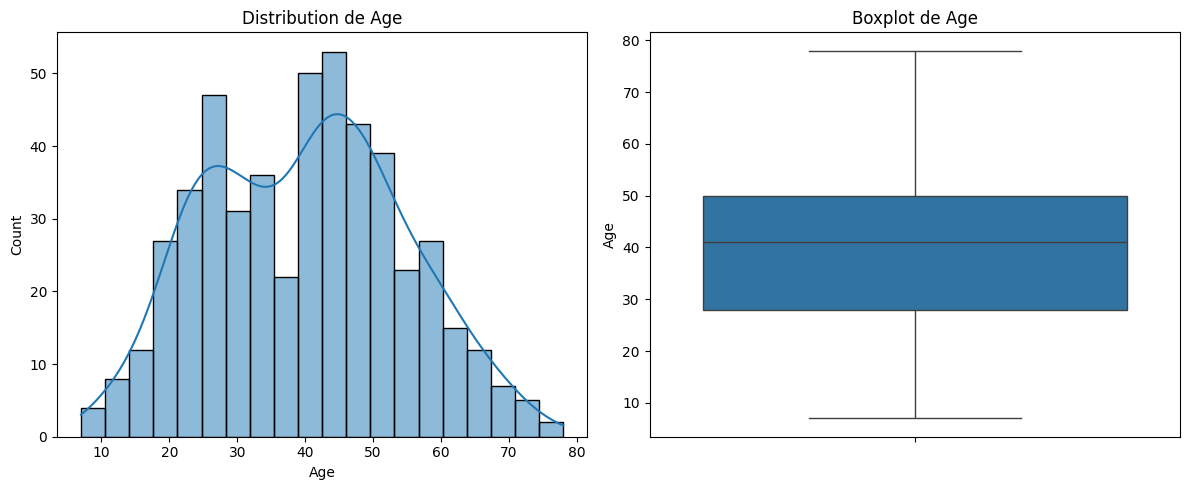

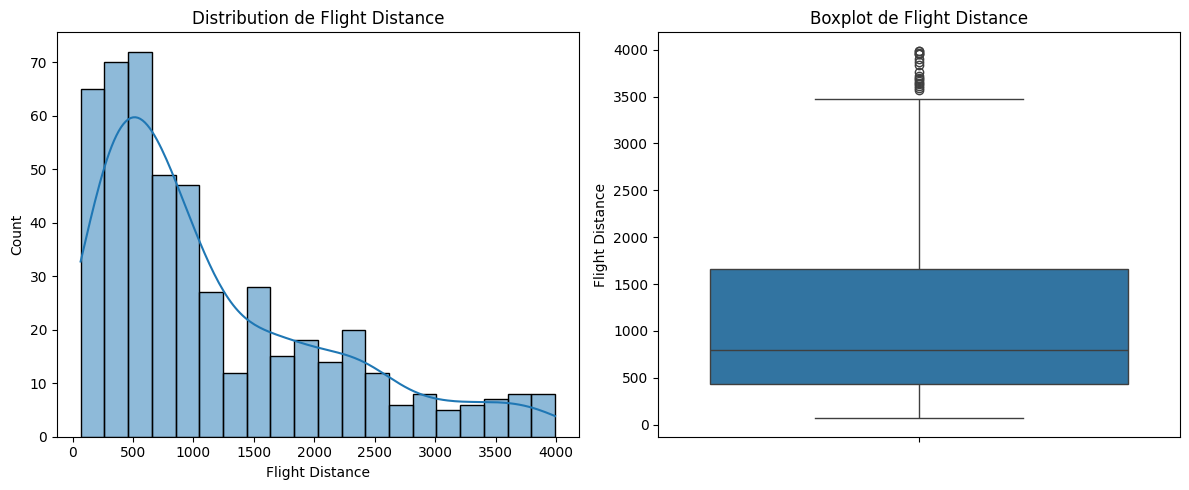

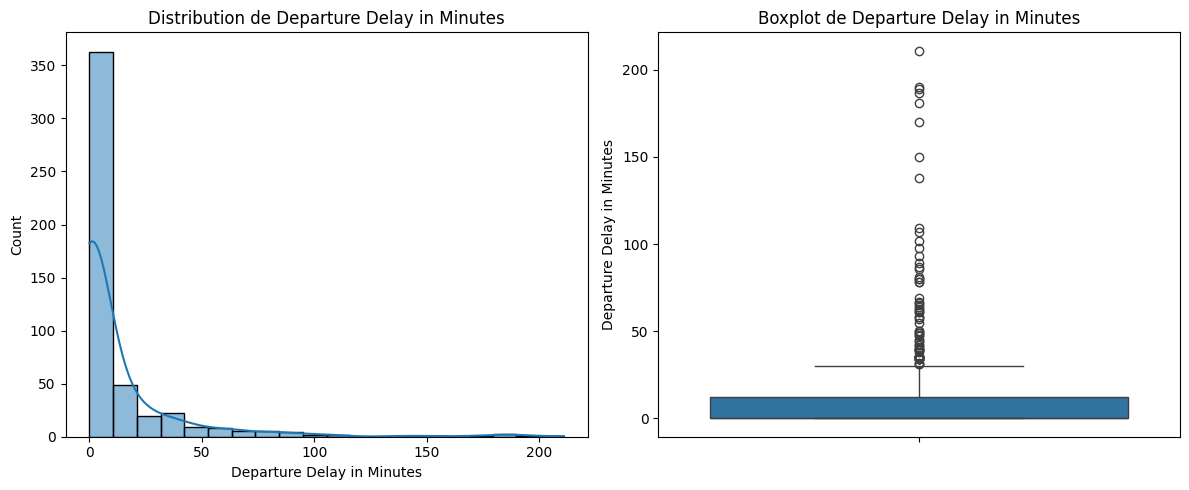

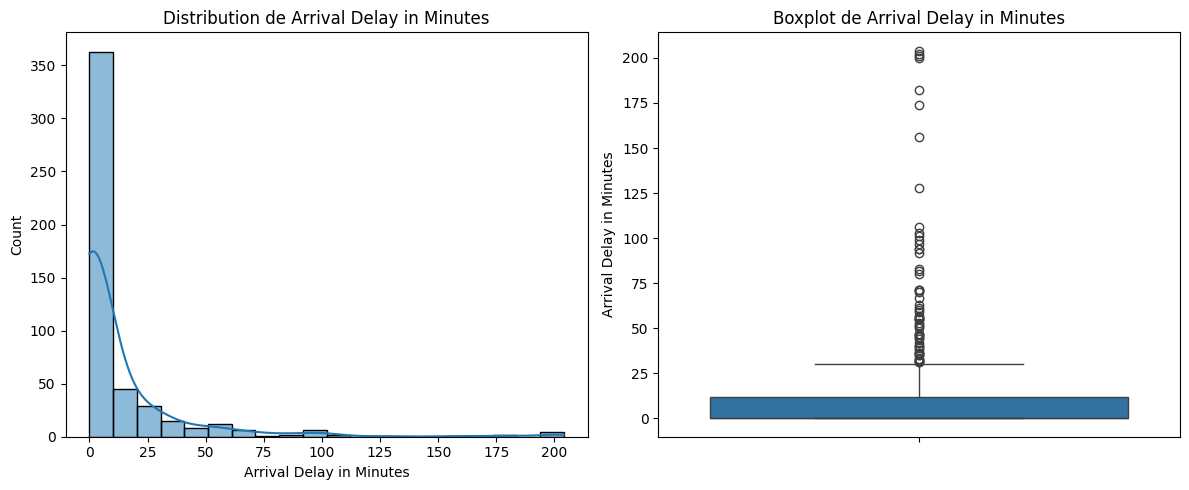

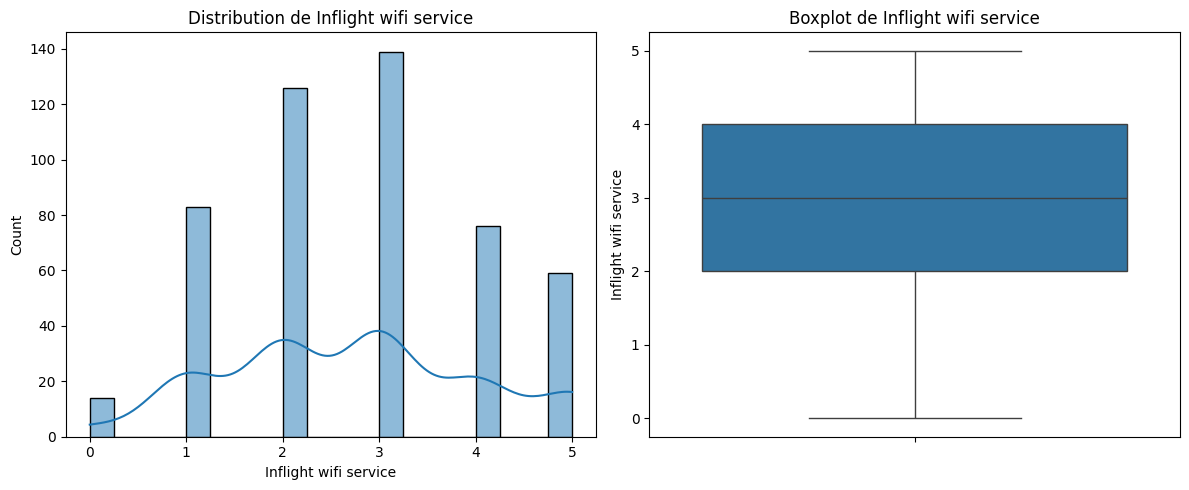

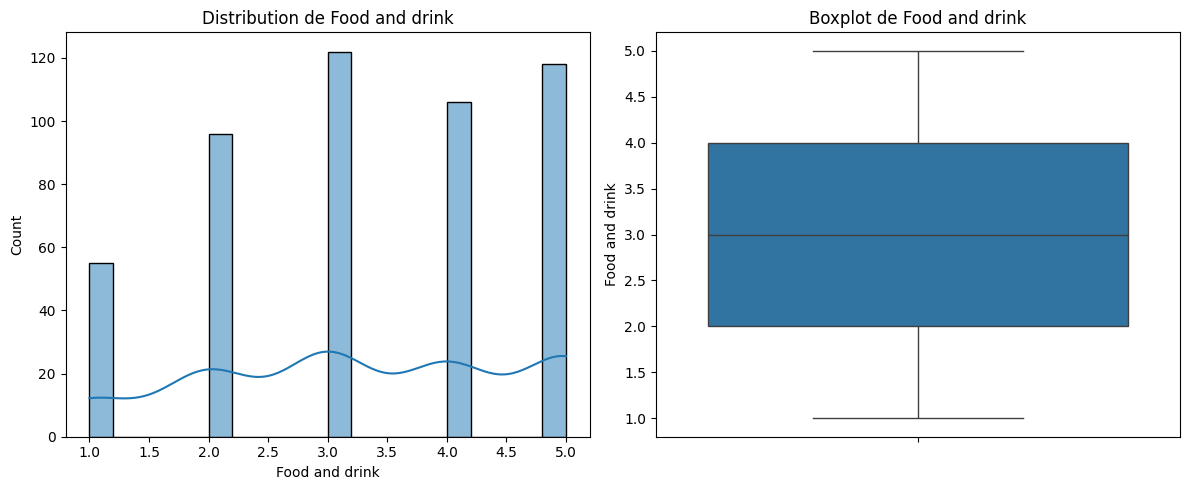

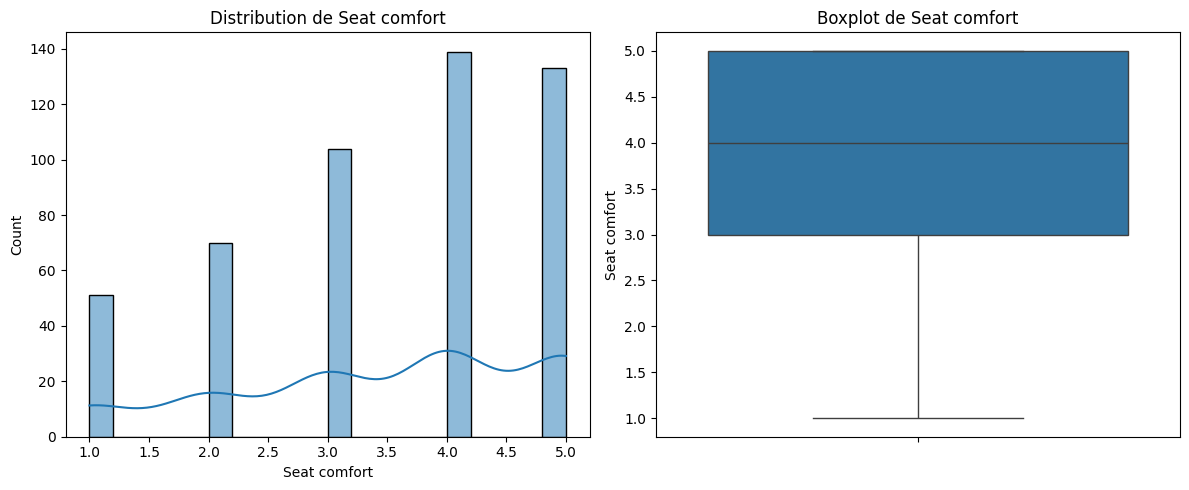

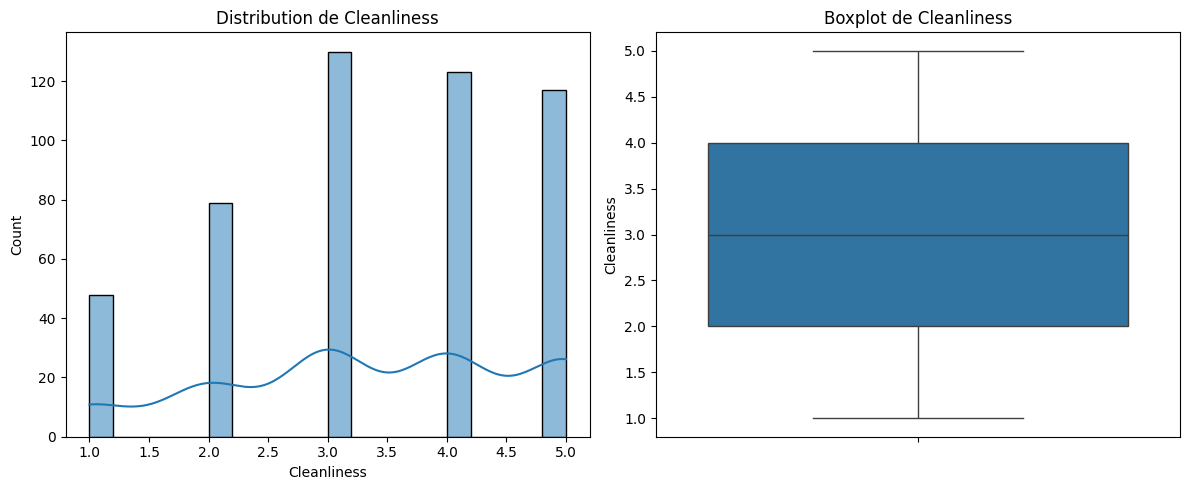

In [6]:


# Visualisation des distributions (histogrammes + boxplots)
for var in quant_vars:
    plt.figure(figsize=(12, 5))

    # Histogramme + KDE
    plt.subplot(1, 2, 1)
    sns.histplot(sample_df_clean[var], kde=True, bins=20)
    plt.title(f'Distribution de {var}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=sample_df_clean[var])
    plt.title(f'Boxplot de {var}')

    plt.tight_layout()
    plt.show()

## Statistiques descriptives : Synthèse des variables clés

### 1. Démographie des passagers

| Variable | Moyenne | Médiane | Distribution | Interprétation |
|----------|---------|---------|--------------|----------------|
| Âge      | ≈ 45 ans | ≈ 45 ans | Symétrique, concentration entre 40-50 ans, outliers <15 et >75 ans | L’âge moyen des passagers est de 45 ans, avec une distribution relativement symétrique. Les valeurs extrêmes reflètent une diversité de la clientèle. |

---

### 2. Distance de vol

| Variable         | Médiane | Distribution | Valeurs extrêmes | Interprétation |
|------------------|---------|--------------|------------------|----------------|
| Flight Distance  | ≈ 600 km | 75% des vols < 1000 km | Jusqu’à 4000 km ; suspicion de vols à 0 km (à vérifier) | La distance médiane des vols est de 600 km, mais la présence de vols longs (> 3500 km) indique une offre variée. Les vols à 0 km nécessitent une vérification. |

---

### 3. Retards

| Variable               | Médiane | Retards extrêmes | Interprétation |
|------------------------|---------|------------------|----------------|
| Departure Delay        | 0 min   | Jusqu’à 200 min  | 75% des vols partent à l’heure. Certains retards extrêmes (>150 min) pourraient impacter la satisfaction client. |
| Arrival Delay          | 0 min   | Jusqu’à 200 min  | Similaire aux départs. Une analyse des causes (météo, maintenance) serait utile. |

---

### 4. Services à bord

| Variable               | Distribution                            | Médiane | Interprétation |
|------------------------|------------------------------------------|---------|----------------|
| Inflight wifi service  | Bimodale : pics à 0 et 5                 | 3       | Service polarisant, besoin d’amélioration. |
| Seat comfort           | Majorité des notes entre 3 et 5          | 4       | Confort perçu comme bon, mais quelques plaintes. |
| Cleanliness            | Similaire à Seat comfort                 | 4       | Propreté généralement appréciée. |
| Food and drink         | Concentration autour de 3–4 (notes 2–5)  | 3.5     | Qualité variable, potentiel d’optimisation. |

> **Résumé :** Les services de Wi-Fi en vol sont les moins bien notés (médiane = 3), avec une polarisation marquée. À l’inverse, le confort et la propreté reçoivent des scores élevés (médiane = 4).


L’analyse univariée révèle une clientèle majoritairement d’âge moyen, voyageant sur des distances courtes à moyennes. Bien que la ponctualité soit généralement respectée, des retards extrêmes peuvent impacter l’expérience client. Les services à bord montrent des disparités : si le confort et la propreté sont bien évalués, le Wi-Fi et la restauration nécessitent des améliorations. Les valeurs aberrantes (vols à 0 km, âges extrêmes) méritent une vérification approfondie.

# Analyse Univariée des Variables Qualitatives


🔵 **Distribution de Gender** :
Gender
Female    50.91
Male      49.09
Name: proportion, dtype: float64



<ipython-input-7-e6ebc6a160ec>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var, data=sample_df_clean, palette="viridis")


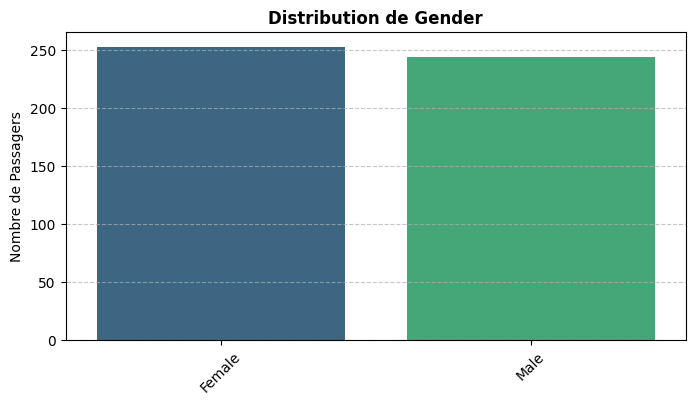


🔵 **Distribution de Customer Type** :
Customer Type
Loyal Customer       82.09
disloyal Customer    17.91
Name: proportion, dtype: float64



<ipython-input-7-e6ebc6a160ec>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var, data=sample_df_clean, palette="viridis")


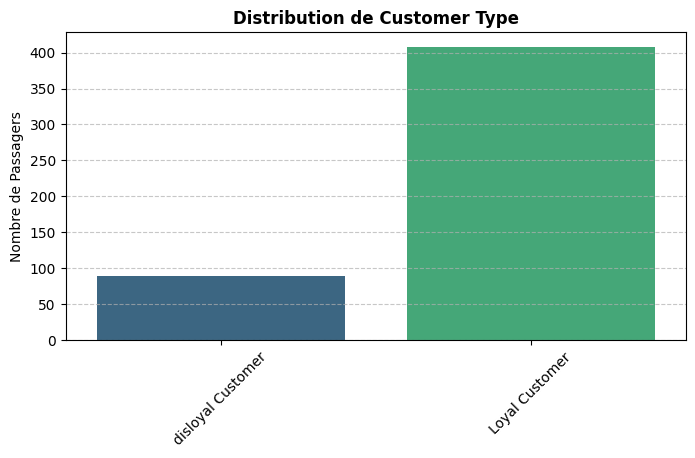

<ipython-input-7-e6ebc6a160ec>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var, data=sample_df_clean, palette="viridis")



🔵 **Distribution de Type of Travel** :
Type of Travel
Business travel    68.01
Personal Travel    31.99
Name: proportion, dtype: float64



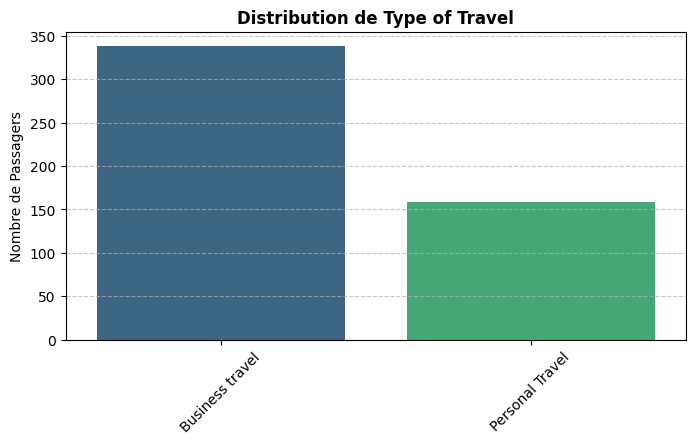


🔵 **Distribution de Class** :
Class
Business    50.30
Eco         43.06
Eco Plus     6.64
Name: proportion, dtype: float64



<ipython-input-7-e6ebc6a160ec>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var, data=sample_df_clean, palette="viridis")


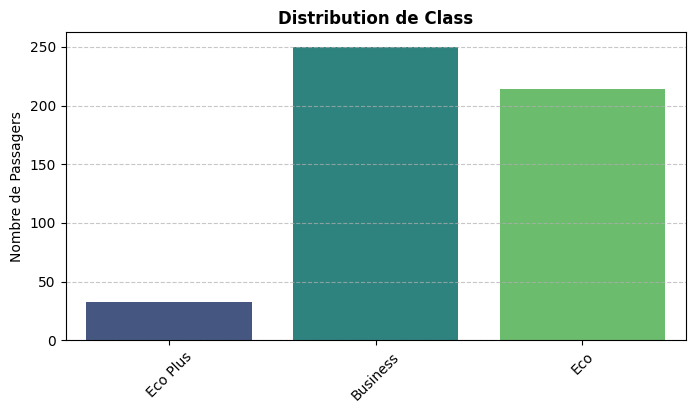

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Variables qualitatives à analyser
qual_vars = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

# 1. Tableaux de fréquences
for var in qual_vars:
    freq = sample_df_clean[var].value_counts(normalize=True) * 100
    print(f"\n🔵 **Distribution de {var}** :\n{freq.round(2)}\n")

# 2. Visualisations (barplots)
    plt.figure(figsize=(8, 4))
    sns.countplot(x=var, data=sample_df_clean, palette="viridis")
    plt.title(f'Distribution de {var}', fontweight='bold')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Nombre de Passagers')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Analyse des Variables Qualitatives

| Variable         | Modalité                  | Pourcentage |
|------------------|----------------------------|-------------|
| **Genre**        | Femmes                     | 50.9 %      |
|                  | Hommes                     | 49.1 %      |
| **Type de client** | Clients fidèles (Loyal)    | 82.1 %      |
|                  | Clients occasionnels       | 17.9 %      |
| **Type de voyage** | Voyages professionnels     | 68.0 %      |
|                  | Voyages personnels         | 32.0 %      |
| **Classe**       | Business                   | 50.3 %      |
|                  | Éco                        | 43.1 %      |
|                  | Éco Plus                   | 6.6 %       |


L’analyse univariée des variables qualitatives révèle une clientèle principalement fidèle et professionnelle, avec une préférence marquée pour la classe Business. La parité hommes-femmes et la faible part de l’Éco Plus soulèvent des questions sur l’adéquation de l’offre aux besoins de niche. Ces résultats orientent vers une stratégie de fidélisation des clients d’affaires et une réévaluation des services Éco Plus.

# Analyse Bivariée

**Variable Quantitative vs. Quantitative**

**Flight Distance vs. Age**

Objectif : Comprendre si les vols longs sont plus fréquents chez certaines tranches d’âge.

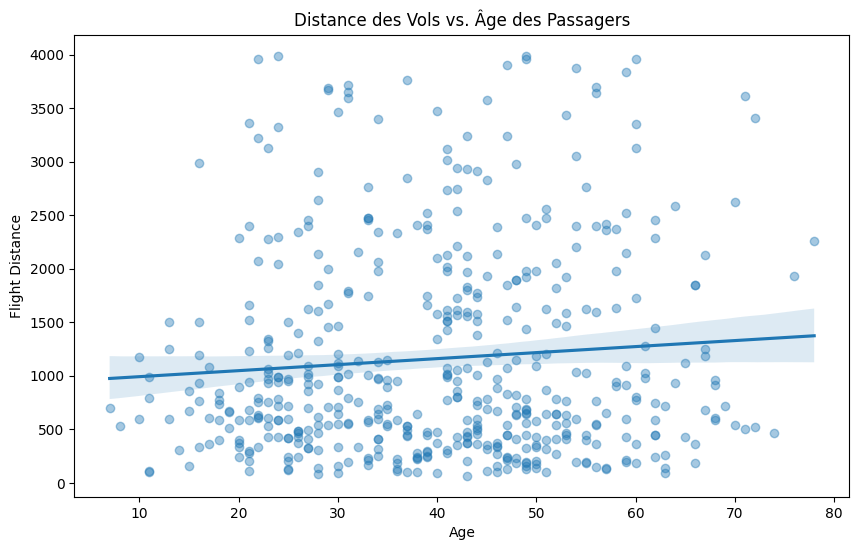

In [8]:
# Nuage de points avec régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x="Age", y="Flight Distance", data=sample_df_clean, scatter_kws={"alpha":0.4})
plt.title("Distance des Vols vs. Âge des Passagers")
plt.show()

Une légère corrélation positive est observée : les passagers plus âgés (40-70 ans) empruntent des vols plus longs .

Les passagers jeunes (20-30 ans) privilégient des vols courts (majorité <1 500 km).

**Departure Delay in Minutes vs. Arrival Delay in Minutes**

Objectif : Vérifier la corrélation entre retards au départ et à l’arrivée.

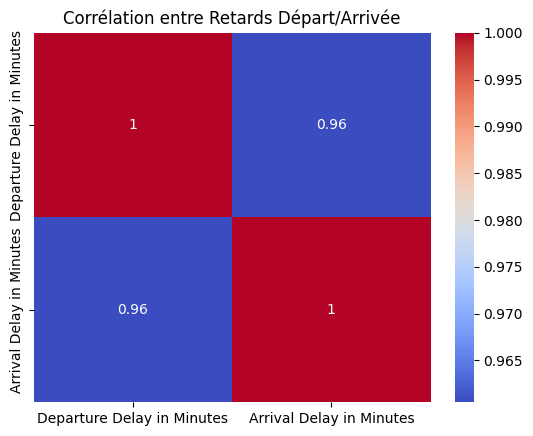

In [9]:
# Matrice de corrélation
corr = sample_df_clean[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Corrélation entre Retards Départ/Arrivée")
plt.show()

Coefficient de corrélation : 0.96 (quasi-parfaite).

Les retards à l’arrivée sont presque entièrement expliqués par les retards au départ

# Variable Quantitative vs. Qualitative

**Age vs. Class**

Objectif : Identifier si certaines classes (Business/Éco) attirent des tranches d’âge spécifiques.



<ipython-input-10-6021c2cb1ef7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="Age", data=sample_df_clean, palette="viridis")


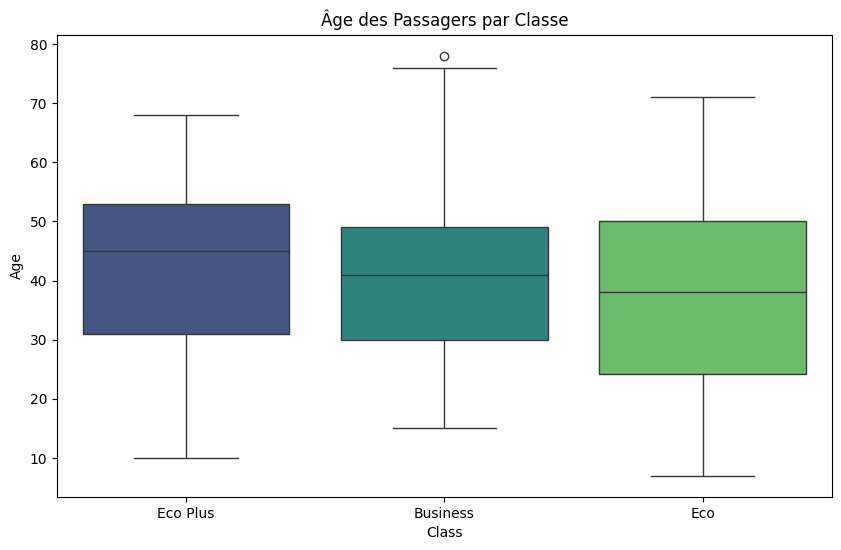

In [10]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Class", y="Age", data=sample_df_clean, palette="viridis")
plt.title("Âge des Passagers par Classe")
plt.show()

Répartition :

* Business : Âge médian ≈ 45 ans (25% >55 ans).

* Éco : Âge médian ≈ 38 ans.

* Éco Plus : Âge médian ≈ 42 ans.

**Flight Distance vs. Type of Travel**

Objectif : Analyser si les voyages professionnels couvrent des distances plus longues.

<ipython-input-11-64c9605bf658>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Type of Travel", y="Flight Distance", data=sample_df_clean, palette="viridis")


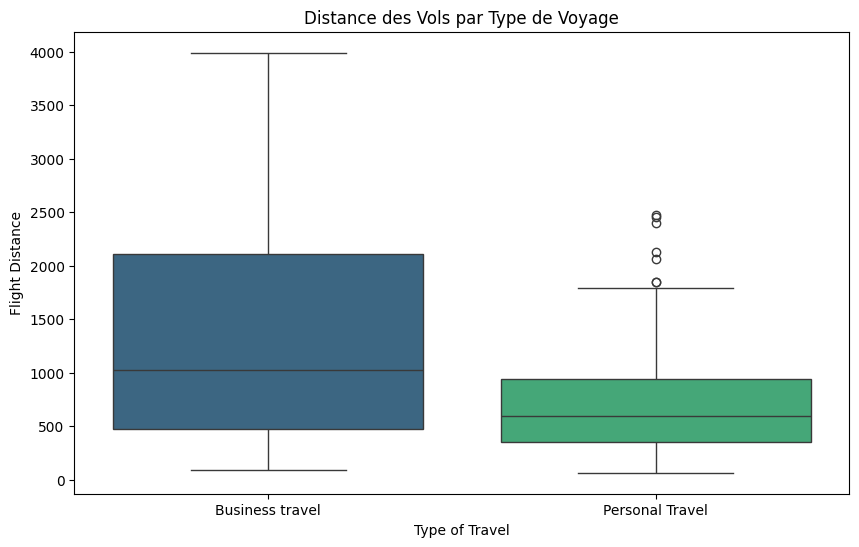

In [11]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Type of Travel", y="Flight Distance", data=sample_df_clean, palette="viridis")
plt.title("Distance des Vols par Type de Voyage")
plt.show()

Distance médiane :

 * Voyages professionnels : 1 200 km.

 * Voyages personnels : 600 km.

**Inflight wifi service vs. Customer Type**

Objectif : Évaluer si la satisfaction vis-à-vis du Wi-Fi diffère entre clients fidèles et occasionnels.

<ipython-input-12-debe5cc35ec3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Customer Type", y="Inflight wifi service", data=sample_df_clean, palette="viridis")


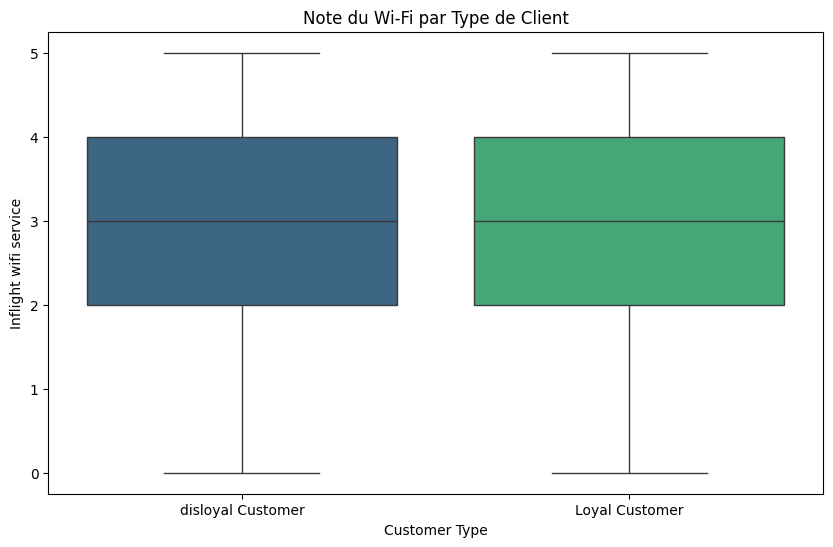

In [12]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Customer Type", y="Inflight wifi service", data=sample_df_clean, palette="viridis")
plt.title("Note du Wi-Fi par Type de Client")
plt.show()

Notes médianes :

Clients fidèles : 3/5.

Clients occasionnels : 3/5.

# Variable Qualitative vs. Qualitative

**Customer Type vs. Class**

Objectif : Savoir si les clients fidèles privilégient la classe Business.

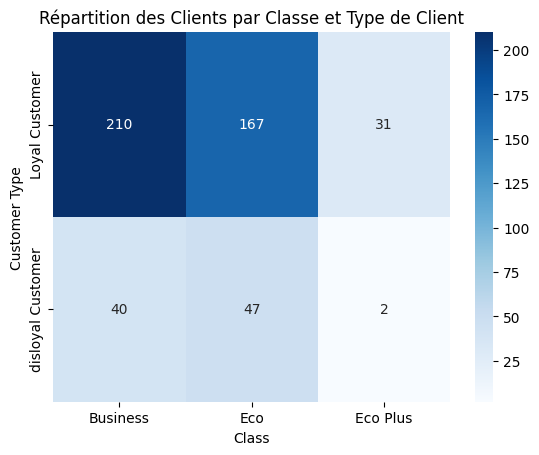

In [13]:
# Tableau de contingence avec heatmap
cross_tab = pd.crosstab(sample_df_clean['Customer Type'], sample_df_clean['Class'])
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="Blues")
plt.title("Répartition des Clients par Classe et Type de Client")
plt.show()

* Clients fidèles :

 * Business : 60% | Éco : 35%.

* Clients occasionnels :

 * Éco : 80% | Business : 15%.

**Type of Travel vs. Class**

Objectif : Vérifier si les voyages professionnels sont majoritairement en classe Business.

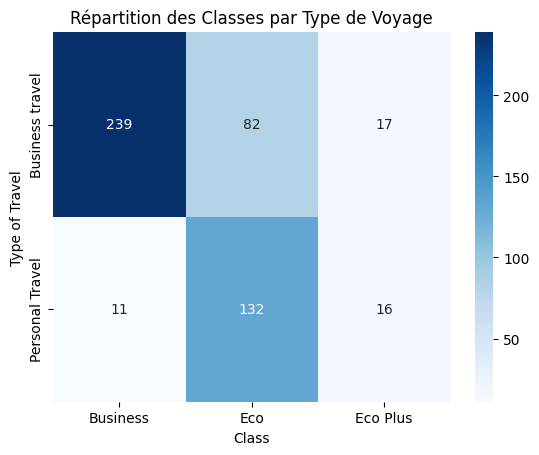

In [14]:
# Tableau de contingence avec heatmap
cross_tab = pd.crosstab(sample_df_clean['Type of Travel'], sample_df_clean['Class'])
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="Blues")
plt.title("Répartition des Classes par Type de Voyage")
plt.show()

* Business travel :

 * Business : 70% des vols.

 * Éco : 25%.

* Personal Travel :

 * Éco : 85% des vols.

# Étape 3 : ACP

1. Sélection des Variables Quantitatives :

Variables incluses :

* Age

* Flight Distance

* Departure Delay in Minutes

* Arrival Delay in Minutes

* Inflight wifi service

* Food and drink

* Seat comfort

* Cleanliness

2. Standardisation des Données

In [15]:
from sklearn.preprocessing import StandardScaler

# Sélection des variables quantitatives
quant_vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes',
              'Arrival Delay in Minutes', 'Inflight wifi service',
              'Food and drink', 'Seat comfort', 'Cleanliness']
X = sample_df_clean[quant_vars]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

3. Vérification des Corrélations

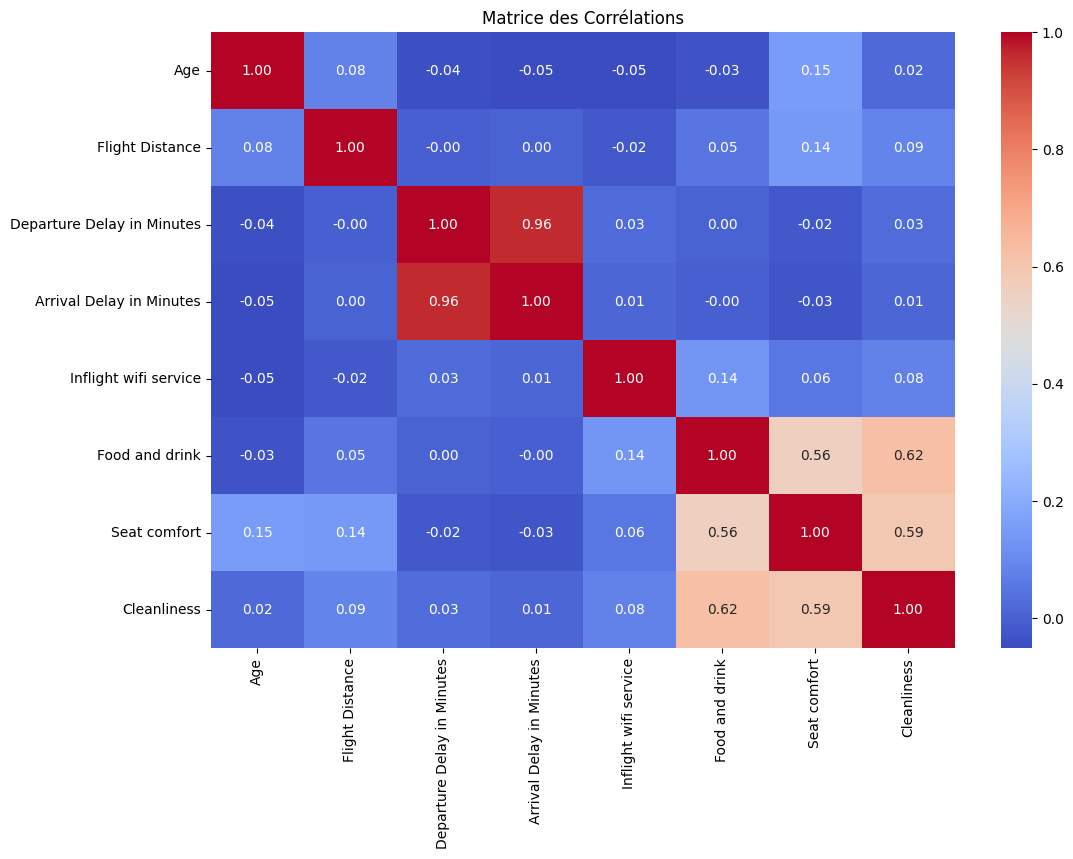

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = pd.DataFrame(X_scaled, columns=quant_vars).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice des Corrélations")
plt.show()

1. Corrélations Fortes (|r| > 0.5)


* Departure Delay in Minutes vs Arrival Delay in Minutes : Corrélation : 0.96

* Food and drink vs Seat comfort : 0.56

* Food and drink vs Cleanliness : 0.62

* Seat comfort vs Cleanliness : 0.59



2. Corrélations Faibles (|r| < 0.3)


* Age : Corrélé faiblement avec toutes les variables (max = 0.15 avec Seat comfort).

* Flight Distance : Aucune corrélation significative (max = 0.14 avec Seat comfort).

* Inflight wifi service : Faible lien avec les autres variables (max = 0.14 avec Food and drink).

4. Application de l’ACP

In [17]:
from sklearn.decomposition import PCA

# ACP avec toutes les composantes
pca = PCA(n_components=None)
principal_components = pca.fit_transform(X_scaled)

5. Analyse des Résultats

In [20]:
import numpy as np

# Nombre de variables initiales
n_variables = 8

# Récupération des variances expliquées
variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance)

# Calcul des valeurs propres
eigenvalues = variance * n_variables

# Tableau récapitulatif
pca_summary = pd.DataFrame({
    'Composante': [f'PC{i+1}' for i in range(len(variance))],
    'Variance Expliquée': variance,
    'Variance Cumulée': cumulative_variance,
    'Valeur Propre (λ)': eigenvalues
})

print(pca_summary.round(3))

  Composante  Variance Expliquée  Variance Cumulée  Valeur Propre (λ)
0        PC1               0.279             0.279              2.232
1        PC2               0.246             0.525              1.967
2        PC3               0.142             0.667              1.134
3        PC4               0.118             0.784              0.941
4        PC5               0.114             0.898              0.912
5        PC6               0.051             0.949              0.406
6        PC7               0.046             0.995              0.369
7        PC8               0.005             1.000              0.039


Les deux méthodes **Règle de Kaiser** et **Variance Cumulée** convergent vers la conservation de 3 composantes, offrant une réduction dimensionnelle efficace tout en capturant l’essentiel de l’information (66.7% de variance). Les composantes PC4 à PC8, non significatives, sont écartées pour éviter le surajustement.  

In [21]:
import pandas as pd

# Récupérer les composantes PCA (loadings) pour les 3 premiers axes
loadings = pca.components_[:3]  # [PC1, PC2, PC3]

# Créer un DataFrame avec les contributions
contrib_table = pd.DataFrame(
    loadings.T,  # Transposer pour avoir les variables en lignes
    columns=['PC1 (27.9%)', 'PC2 (24.6%)', 'PC3 (14.2%)'],  # Remplacer ??% par la variance expliquée de PC3
    index=quant_vars  # Liste des variables quantitatives
)

# Formater les valeurs pour une meilleure lisibilité
contrib_table = contrib_table.round(2)

# Afficher le tableau
print("Contribution des variables aux 3 premiers axes de l'ACP :")
display(contrib_table)

Contribution des variables aux 3 premiers axes de l'ACP :


,PC1 (27.9%),PC2 (24.6%),PC3 (14.2%)
Age,0.07,-0.07,0.66
Flight Distance,0.13,-0.01,0.53
Departure Delay in Minutes,-0.01,0.70,0.05
Arrival Delay in Minutes,-0.02,0.70,0.06
Inflight wifi service,0.12,0.03,-0.48
Food and drink,0.56,0.02,-0.17
Seat comfort,0.56,-0.02,0.13
Cleanliness,0.57,0.03,-0.06


1. Composante 1 (PC1 : 27.9% de variance)

Variables dominantes :

Cleanliness (0.57)

Seat comfort (0.56)

Food and drink (0.56).

Interprétation :

"La PC1 représente la satisfaction globale des services à bord. Les passagers qui donnent des notes élevées à la propreté, au confort des sièges et à la qualité de la nourriture contribuent fortement à cet axe. Les variables associées sont fortement corrélées entre elles, ce qui suggère une dimension latente commune liée à la qualité perçue des services."

2. Composante 2 (PC2 : 24.6% de variance)

Variables dominantes :

Departure Delay in Minutes (0.70)

Arrival Delay in Minutes (0.70).

Interprétation :

*"La PC2 reflète l’impact des retards de vol. Les retards au départ et à l’arrivée sont quasi redondants (r=0.96), ce qui explique leur forte contribution à cet axe. Cet axe oppose les vols ponctuels (scores négatifs) aux vols avec retards significatifs (scores positifs)."*

3. Composante 3 (PC3 : 14.2% de variance)

Variables dominantes :

Age (0.66)

Flight Distance (0.53)

Inflight wifi service (-0.48).

Interprétation :

*"La PC3 capture une opposition démographique et comportementale :

Pôle positif : Passagers âgés effectuant des vols longs (contributions positives de Age et Flight Distance).

Pôle négatif : Passagers jeunes insatisfaits du service Wi-Fi (contribution négative de Inflight wifi service)."*

**Nuage des Individus**

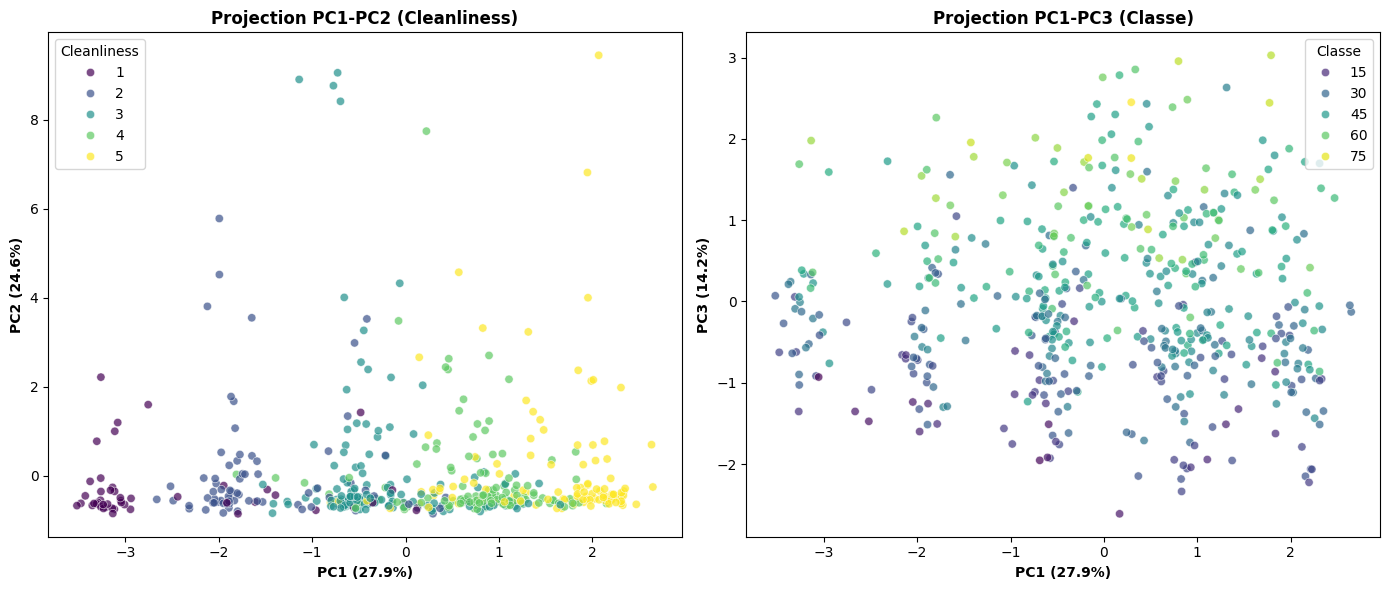

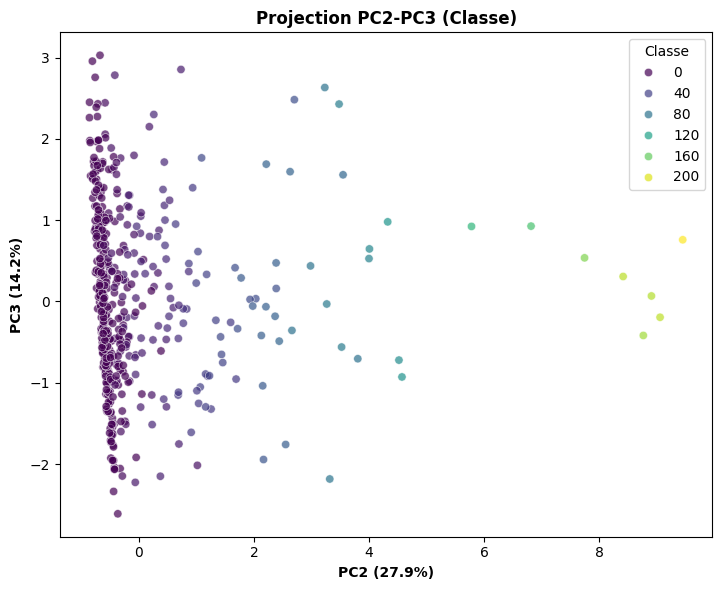

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Projection PC1-PC2
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=sample_df_clean['Cleanliness'],
    palette="viridis",
    alpha=0.7
)
plt.xlabel("PC1 (27.9%)", fontweight='bold')
plt.ylabel("PC2 (24.6%)", fontweight='bold')
plt.title("Projection PC1-PC2 (Cleanliness)", fontweight='bold')
plt.legend(title='Cleanliness')

# Projection PC1-PC3
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 2],
    hue=sample_df_clean['Age'],
    palette="viridis",
    alpha=0.7
)
plt.xlabel("PC1 (27.9%)", fontweight='bold')
plt.ylabel("PC3 (14.2%)", fontweight='bold')
plt.title("Projection PC1-PC3 (Age)", fontweight='bold')
plt.legend(title='Age')

plt.tight_layout()
plt.show()

# Projection PC2-PC3
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=principal_components[:, 1],
    y=principal_components[:, 2],
    hue=sample_df_clean['Departure Delay in Minutes'],
    palette="viridis",
    alpha=0.7
)
plt.xlabel("PC2 (27.9%)", fontweight='bold')
plt.ylabel("PC3 (14.2%)", fontweight='bold')
plt.title("Projection PC2-PC3 (ClaDeparture Delay in Minutessse)", fontweight='bold')
plt.legend(title='Departure Delay in Minutes')

plt.tight_layout()
plt.show()

* PC1-PC2 (Colorée par Cleanliness)
Distribution :

 * PC1 (27.9%) : Les passagers avec des scores élevés de Cleanliness (propreté) se situent à droite (PC1 > 0).

 * PC2 (24.6%) : Les retards (Departure Delay) sont répartis verticalement, sans lien avec la propreté.


"La propreté est un facteur clé de satisfaction (PC1 positif). Les retards (PC2) ne sont pas corrélés à la propreté, affectant toutes les catégories de clients."

* PC1-PC3 (Colorée par Age)
Distribution :

 * PC1 : Les seniors (âges élevés) sont légèrement plus à droite (PC1 > 0), indiquant une satisfaction légèrement supérieure.

 * PC3 (14.2%) : Les jeunes (âges faibles) sont en bas (PC3 < 0), associés à une insatisfaction du Wi-Fi.


*"Les seniors sont plus satisfaits des services globaux (PC1), tandis que les jeunes expriment une insatisfaction marquée envers le Wi-Fi (PC3 négatif)."*

* PC2-PC3 (Colorée par Departure Delay)
Distribution :

 * PC2 : Les retards élevés (Departure Delay > 0) dominent le haut du graphique.

 * PC3 : Aucun lien clair entre retards et profil démographique (PC3).


"Les retards (PC2) impactent indépendamment de l’âge ou de la distance des vols, confirmant leur universalité."



**Cercles des Corrélations**

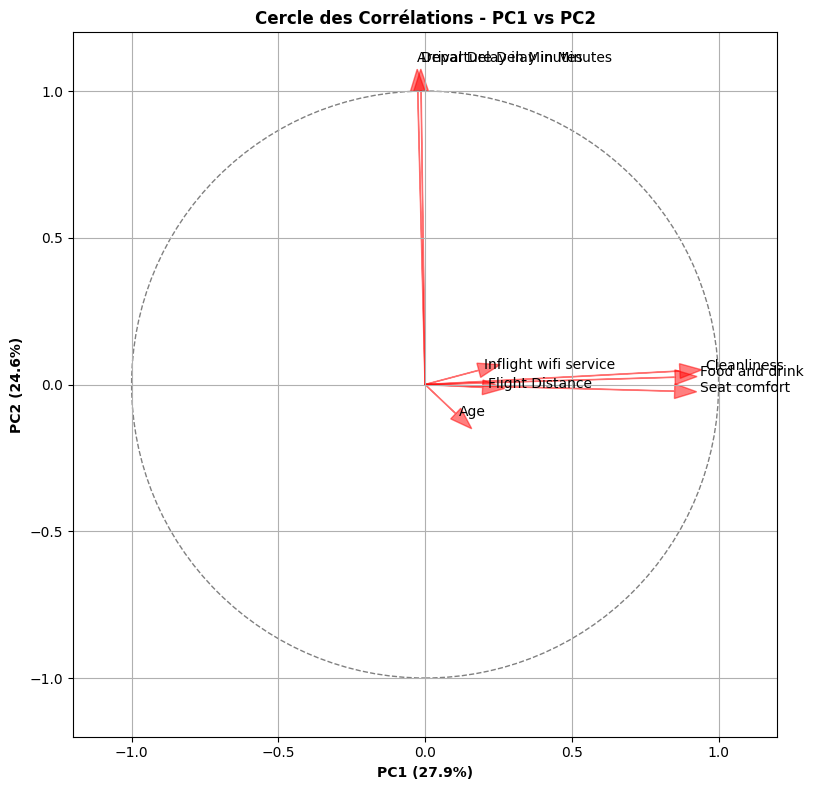

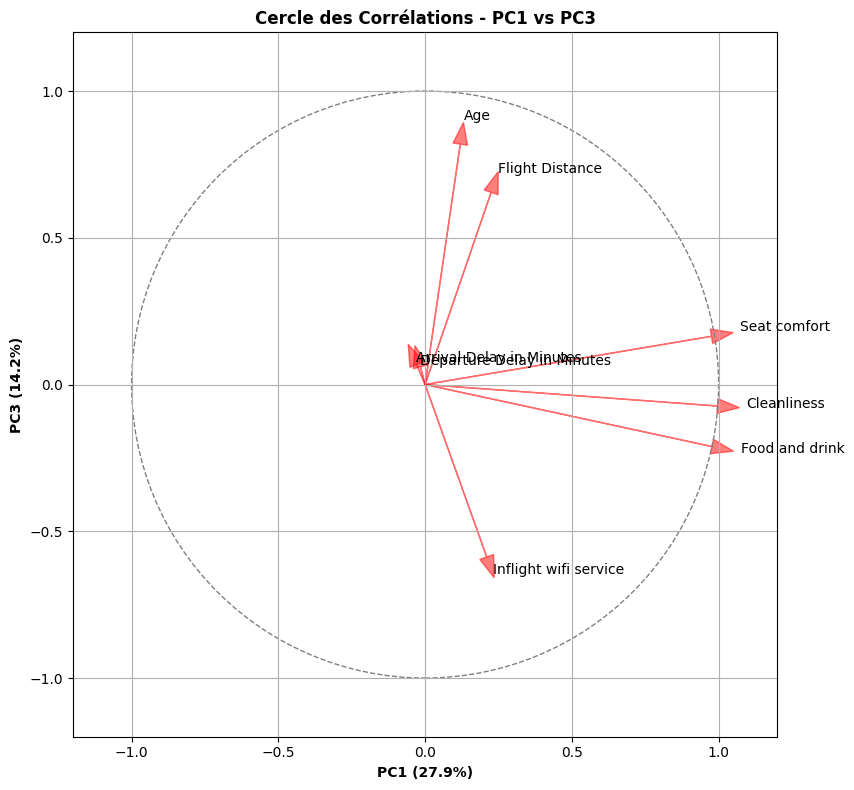

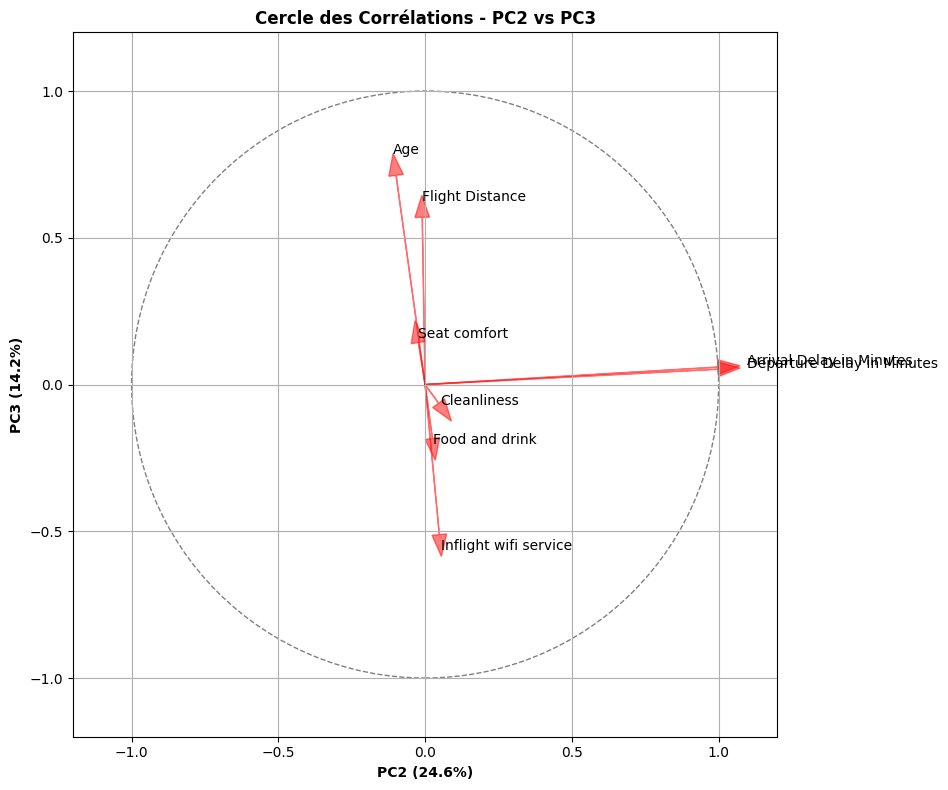

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction générique pour le cercle des corrélations
def plot_correlation_circle(components, quant_vars, x_idx=0, y_idx=1, title=""):
    # Normaliser les coordonnées pour que les flèches restent dans le cercle
    norms = np.sqrt(components[:, x_idx]**2 + components[:, y_idx]**2)
    components_normalized = components / norms.max()  # Redimensionner pour ne pas dépasser le cercle

    # Création du graphique
    plt.figure(figsize=(10, 8))

    for i, var in enumerate(quant_vars):
        # Tracer les flèches avec des coordonnées normalisées
        plt.arrow(0, 0,
                  components_normalized[i, x_idx],
                  components_normalized[i, y_idx],
                  head_width=0.05,
                  color='red',
                  alpha=0.5)
        # Ajouter les labels des variables
        plt.text(components_normalized[i, x_idx] * 1.1,
                 components_normalized[i, y_idx] * 1.1,
                 var,
                 color='black',
                 fontsize=10)

    # Labels des axes avec les pourcentages de variance expliquée
    plt.xlabel(f"PC{x_idx+1} ({pca.explained_variance_ratio_[x_idx]*100:.1f}%)", fontweight='bold')
    plt.ylabel(f"PC{y_idx+1} ({pca.explained_variance_ratio_[y_idx]*100:.1f}%)", fontweight='bold')
    plt.title(title, fontweight='bold')

    # Ajouter le cercle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

    # Ajuster la vue
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')  # Pour que le cercle ne soit pas déformé
    plt.tight_layout()
    plt.show()

# Calcul des composantes pour le cercle (loadings normalisés)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_ratio_)

# Variables quantitatives (assumes they exist in your dataset)
quant_vars = [
    'Age', 'Flight Distance', 'Departure Delay in Minutes',
    'Arrival Delay in Minutes', 'Inflight wifi service',
    'Food and drink', 'Seat comfort', 'Cleanliness'
]

# Cercle PC1-PC2
plot_correlation_circle(
    loadings,
    quant_vars,
    x_idx=0,
    y_idx=1,
    title="Cercle des Corrélations - PC1 vs PC2"
)

# Cercle PC1-PC3
plot_correlation_circle(
    loadings,
    quant_vars,
    x_idx=0,
    y_idx=2,
    title="Cercle des Corrélations - PC1 vs PC3"
)

# Cercle PC2-PC3
plot_correlation_circle(
    loadings,
    quant_vars,
    x_idx=1,
    y_idx=2,
    title="Cercle des Corrélations - PC2 vs PC3"
)


* PC1-PC2

 * PC1 : Cleanliness (0.57), Seat comfort (0.56), Food and drink (0.56) ➔ Satisfaction des services.

 * PC2 : Departure Delay (0.70), Arrival Delay (0.70) ➔ Retards.

Orthogonalité : Les services et les retards sont des dimensions indépendantes.

* PC1-PC3

 * PC1 : Satisfaction des services.

 * PC3 : Age (0.66), Flight Distance (0.53) vs Inflight wifi service (-0.48) ➔ Opposition jeunes/seniors.

"Les seniors privilégient les vols longs, tandis que les jeunes critiquent le Wi-Fi."

* PC2-PC3
Variables clés :

 * PC2 : Retards.

 * PC3 : Démographie.

Aucune corrélation : Les retards ne sont pas liés à l’âge ou à la distance.



# Etape 4 : ACM

1. Sélection des Variables Qualitatives


Choisissez les variables qualitatives pertinentes pour l’ACM. Dans votre cas :

Gender (Male/Female)

Customer Type (Loyal/disloyal)

Type of Travel (Business travel/Personal Travel)

Class (Business/Eco/Eco Plus)

2. Création du Tableau Disjonctif Complet (TDC)

In [24]:
# Encodage disjonctif
qual_vars = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
df_qual = sample_df_clean[qual_vars]
df_dummies = pd.get_dummies(df_qual)

3. Application de l’ACM

In [30]:
from prince import MCA

# Appliquer l'ACM
mca = MCA(n_components=2, n_iter=3, random_state=42)
mca.fit(df_dummies)

MCA(n_iter=3, random_state=42)

4. Visualisation des Résultats

* Projection des Modalités

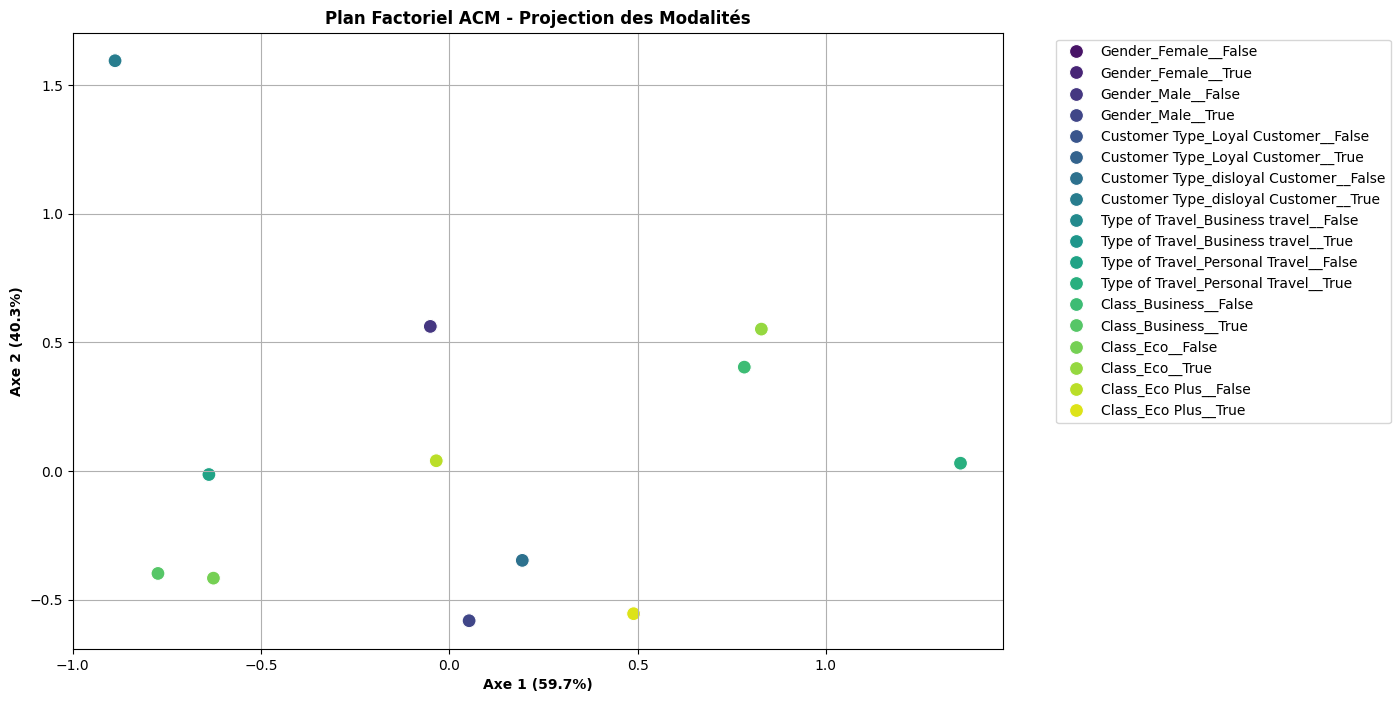

In [35]:
# Extraire les inerties expliquées
eigvals = np.array(mca.eigenvalues_)
explained_inertia = eigvals / eigvals.sum()

# Coordonnées des modalités
mca_coords = mca.column_coordinates(df_dummies)

# Visualisation
plt.figure(figsize=(12, 8))
sns.scatterplot(x=mca_coords[0], y=mca_coords[1], hue=mca_coords.index, s=100, palette="viridis")
plt.xlabel(f"Axe 1 ({explained_inertia[0]*100:.1f}%)", fontweight='bold')
plt.ylabel(f"Axe 2 ({explained_inertia[1]*100:.1f}%)", fontweight='bold')
plt.title("Plan Factoriel ACM - Projection des Modalités", fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

### 1. Variance Expliquée

| Axe     | Pourcentage de variance expliquée |
|---------|------------------------------------|
| Axe 1   | 59.7 %                             |
| Axe 2   | 40.3 %                             |
| **Total** | **100 %**                         |


### 4. Projection des Modalités

| Groupe                | Modalités clés                                                                 |
|-----------------------|---------------------------------------------------------------------------------|
| **Groupe 1 (Axe 1 < 0)** | Type of Travel_Business travel__True, Customer Type_Loyal Customer__True       |
| **Groupe 2 (Axe 1 > 0)** | Type of Travel_Personal Travel__True, Customer Type_disloyal Customer__True    |


In [41]:
# 3. Contribution des modalités à chaque axe
contributions = (mca_coords ** 2).div(eigvals, axis=1)

# 4. Cos² (qualité de représentation sur chaque axe)
cos2 = (mca_coords ** 2).div((mca_coords ** 2).sum(axis=1), axis=0)

# 5. Fusion des résultats dans un seul tableau
summary = pd.concat([
    mca_coords.rename(columns=lambda x: f"Coord Axe {x+1}"),
    contributions.rename(columns=lambda x: f"CTR Axe {x+1}"),
    cos2.rename(columns=lambda x: f"Cos2 Axe {x+1}")
], axis=1)

# 6. Affichage
pd.set_option('display.max_rows', None)  # pour afficher toutes les modalités si besoin
print(summary.round(3))

                                        Coord Axe 1  Coord Axe 2  CTR Axe 1  \
Gender_Female__False                          0.052       -0.582      0.008   
Gender_Female__True                          -0.051        0.562      0.007   
Gender_Male__False                           -0.051        0.562      0.007   
Gender_Male__True                             0.052       -0.582      0.008   
Customer Type_Loyal Customer__False          -0.888        1.594      2.200   
Customer Type_Loyal Customer__True            0.194       -0.348      0.105   
Customer Type_disloyal Customer__False        0.194       -0.348      0.105   
Customer Type_disloyal Customer__True        -0.888        1.594      2.200   
Type of Travel_Business travel__False         1.358        0.030      5.142   
Type of Travel_Business travel__True         -0.639       -0.014      1.138   
Type of Travel_Personal Travel__False        -0.639       -0.014      1.138   
Type of Travel_Personal Travel__True          1.358 


### 2. Contribution des Modalités aux Axes (CTR)

#### Axe 1 (59.7 %)

| Modalité                                 | Contribution (CTR) |
|------------------------------------------|---------------------|
| Type of Travel_Business travel__False    | 5.14                |
| Type of Travel_Personal Travel__True     | 5.14                |
| Customer Type_disloyal Customer__True    | 2.20                |

#### Axe 2 (40.3 %)

| Modalité                                 | Contribution (CTR) |
|------------------------------------------|---------------------|
| Customer Type_Loyal Customer__False      | 10.51               |
| Customer Type_disloyal Customer__True    | 10.51               |
| Class_Eco Plus__True                     | 1.27                |

### 3. Qualité de Représentation (Cos²)

| Modalité                                 | Axe associé | Cos²  |
|------------------------------------------|-------------|--------|
| Type of Travel_Business travel__False    | Axe 1       | 1.00   |
| Customer Type_Loyal Customer__False      | Axe 2       | 0.76   |






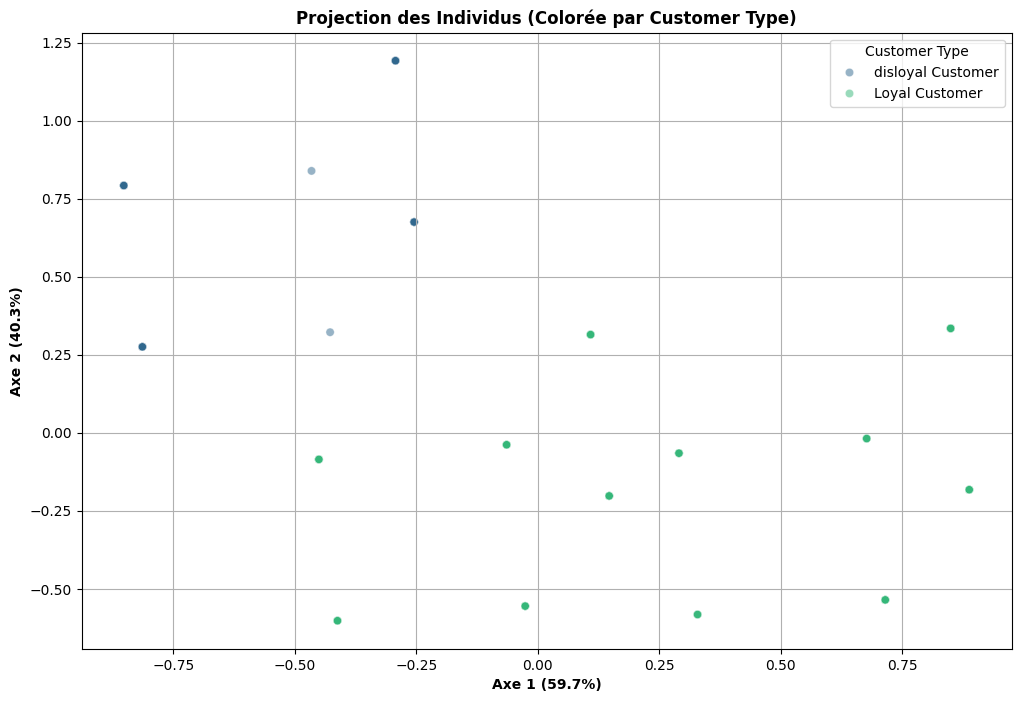

In [50]:
# Calcul de l'inertie expliquée
eigvals = np.array(mca.eigenvalues_)
explained_inertia = eigvals / eigvals.sum()

# Coordonnées des individus
individus_coords = mca.row_coordinates(df_dummies)

# Visualisation
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=individus_coords[0],
    y=individus_coords[1],
    hue=sample_df_clean['Customer Type'],
    palette="viridis",
    alpha=0.5
)
plt.xlabel(f"Axe 1 ({explained_inertia[0]*100:.1f}%)", fontweight='bold')
plt.ylabel(f"Axe 2 ({explained_inertia[1]*100:.1f}%)", fontweight='bold')
plt.title("Projection des Individus (Colorée par Customer Type)", fontweight='bold')
plt.legend(title='Customer Type')
plt.grid()
plt.show()


- **Coloration par Customer Type** :
  - *Loyal Customer* : regroupés en bas  (confirmant la structuration par l’Axe 2).

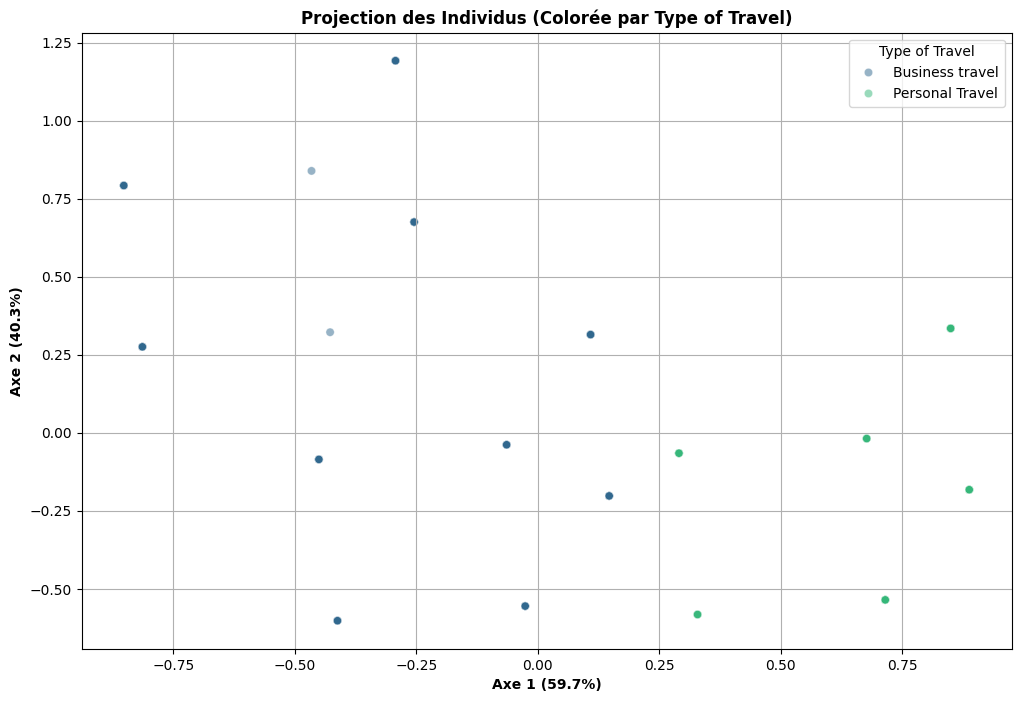

In [48]:
# Calcul de l'inertie expliquée
eigvals = np.array(mca.eigenvalues_)
explained_inertia = eigvals / eigvals.sum()

# Coordonnées des individus
individus_coords = mca.row_coordinates(df_dummies)

# Visualisation
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=individus_coords[0],
    y=individus_coords[1],
    hue=sample_df_clean['Type of Travel'],
    palette="viridis",
    alpha=0.5
)
plt.xlabel(f"Axe 1 ({explained_inertia[0]*100:.1f}%)", fontweight='bold')
plt.ylabel(f"Axe 2 ({explained_inertia[1]*100:.1f}%)", fontweight='bold')
plt.title("Projection des Individus (Colorée par Type of Travel)", fontweight='bold')
plt.legend(title='Type of Travel')
plt.grid()
plt.show()


- **Coloration par Type de voyage** :
  - *Business travel* : regroupés à gauche (confirmant la structuration par l’Axe 1).

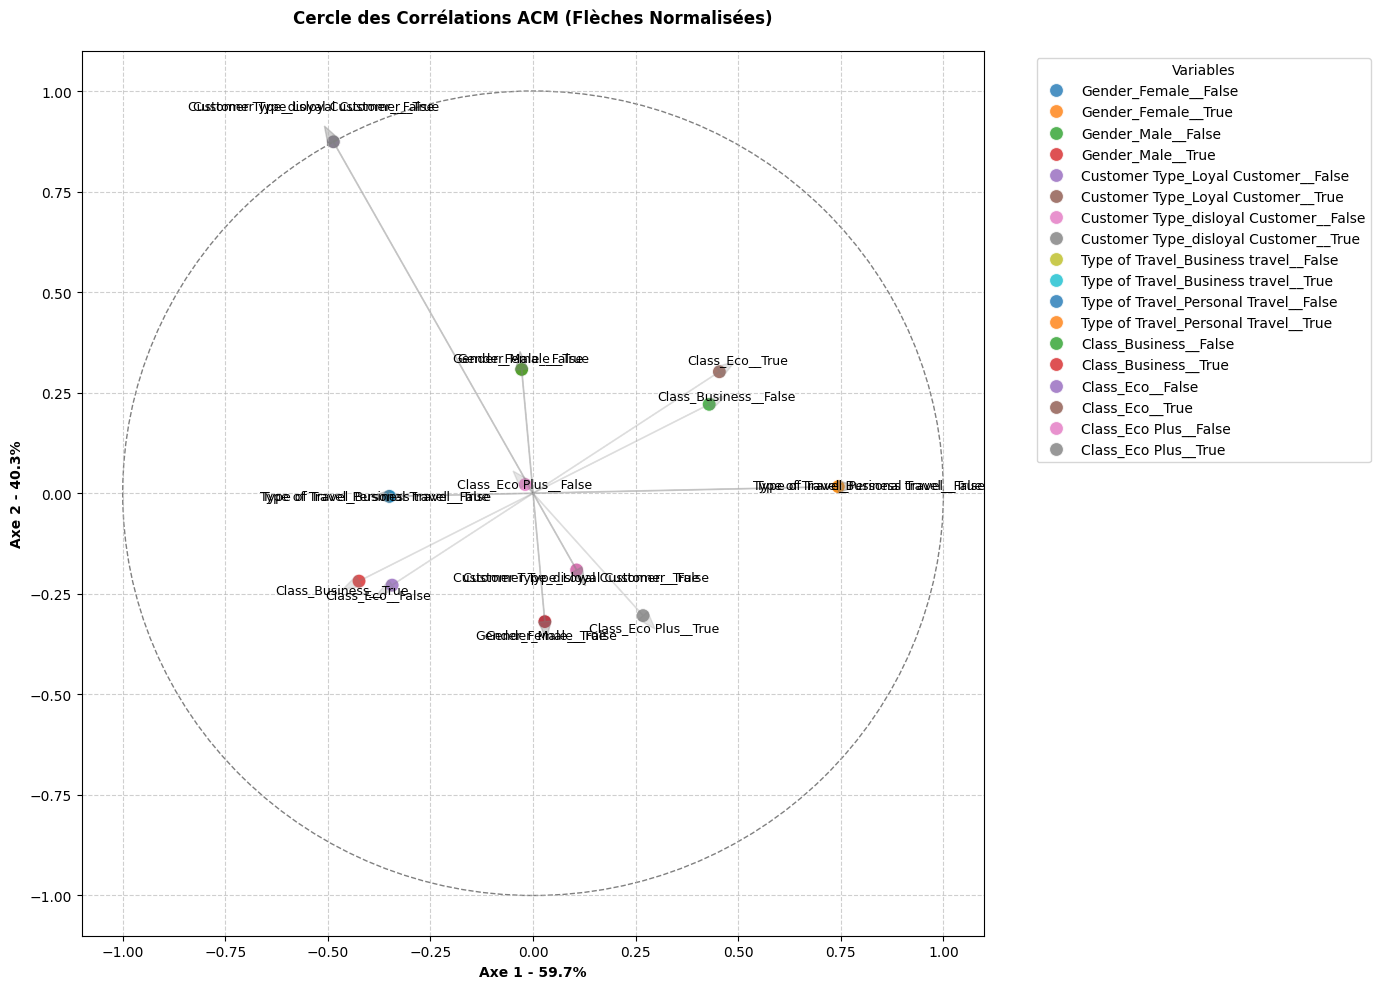

In [53]:
# Normalisation pour garder les flèches dans le cercle
norms = np.sqrt(mca_coords[0]**2 + mca_coords[1]**2)
max_norm = norms.max()
scaled_coords = mca_coords / max_norm  # ramène à norme <= 1

# Taille du graphique
plt.figure(figsize=(14, 10))

# Cercle des corrélations avec flèches redimensionnées
sns.scatterplot(
    x=scaled_coords[0],
    y=scaled_coords[1],
    hue=scaled_coords.index.get_level_values(0),
    palette="tab10",
    s=100,
    alpha=0.8
)

# Ajouter des flèches et étiquettes
for i, (x, y) in enumerate(zip(scaled_coords[0], scaled_coords[1])):
    plt.arrow(0, 0, x, y, color='grey', alpha=0.2, head_width=0.03)
    plt.text(x * 1.1, y * 1.1,
             scaled_coords.index[i],
             color='black',
             fontsize=9,
             ha='center',
             va='center')

# Cercle unité
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Axes et titres
plt.xlabel(f"Axe 1 - {explained_inertia[0]*100:.1f}%", fontweight='bold')
plt.ylabel(f"Axe 2 - {explained_inertia[1]*100:.1f}%", fontweight='bold')
plt.title("Cercle des Corrélations ACM (Flèches Normalisées)", fontweight='bold', pad=20)

# Légende
plt.legend(
    title="Variables",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Ajustements
plt.grid(linestyle='--', alpha=0.6)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()


 Séparation Nette entre Profils Professionnels et Personnels

#### Axe 1 (59.7 % de variance expliquée)

| Position sur l’Axe 1 |  Modalités associées                                     |                                                  |                              
|-----------------------|--------------------------------------------------------|-----------------------------------------------------------|
| Côté gauche (< 0)     | Type of Travel_Business travel__True<br>Customer Type_Loyal Customer__True<br>Class_Business__True |
| Côté droit (> 0)      | Type of Travel_Personal Travel__True<br>Customer Type_disloyal Customer__True<br>Class_Eco__True  |

Axe 2 (40.3 % de variance expliquée)

| Position sur l’Axe 2 | Modalités associées                                     |                                                  |
|-----------------------|----------------------------------------------------------|------------------------------------------------------------------------|
| Pôle inferieur (< 0)  | Customer Type_disloyal Customer__True<br>Class_Eco Plus__True |
| Pôle supérieur (> 0)  | Customer Type_Loyal Customer__True                           |
### 2. Structure des Axes

#### Axe 1

- Pourcentage de variance : **59.7 %**
- Variables principales : `Type of Travel` (Business vs Personal), `Customer Type` (Loyal vs Disloyal)

#### Axe 2

- Pourcentage de variance : **40.3 %**
- Variables principales : `Class_Eco Plus__True`, `Gender_Female__True`


### 6. Synthèse Globale

- Axe 1 distingue les voyages professionnels (clients fidèles) des voyages personnels (clients occasionnels).
- Axe 2 sépare les clients fidèles des occasionnels, avec une modalité marginale pour la classe Éco Plus.

#Etape 5 : Classification (CAH + K-means)

In [57]:
# Récupérer les composantes principales (PC1, PC2, PC3)
X_pca = principal_components[:, :3]

 * Classification Ascendante Hiérarchique (CAH)

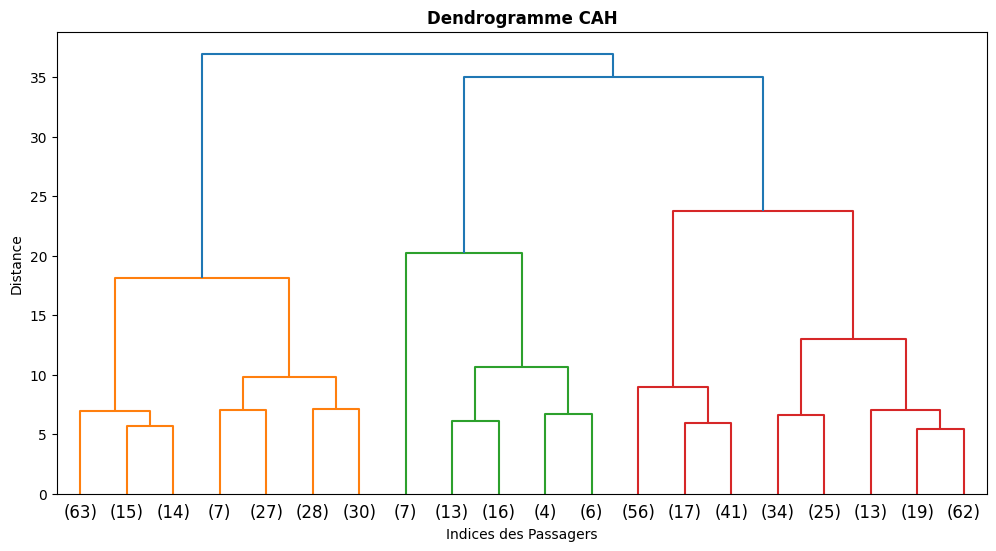

In [58]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Calcul de la matrice de liaison avec la méthode de Ward
Z = linkage(X_pca, method='ward')

# Tracé du dendrogramme
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=20, show_leaf_counts=True)
plt.title("Dendrogramme CAH", fontweight='bold')
plt.xlabel("Indices des Passagers")
plt.ylabel("Distance")
plt.show()

In [70]:
from scipy.cluster.hierarchy import fcluster

# Choix du nombre de clusters (ex. : 3)
clusters_cah = fcluster(Z, t=3, criterion='maxclust')

# Ajout des clusters au DataFrame
sample_df_clean = sample_df_clean.copy()  # Ajoute cette ligne avant d'assigner la colonne
sample_df_clean['Cluster_CAH'] = clusters_cah


* K-means

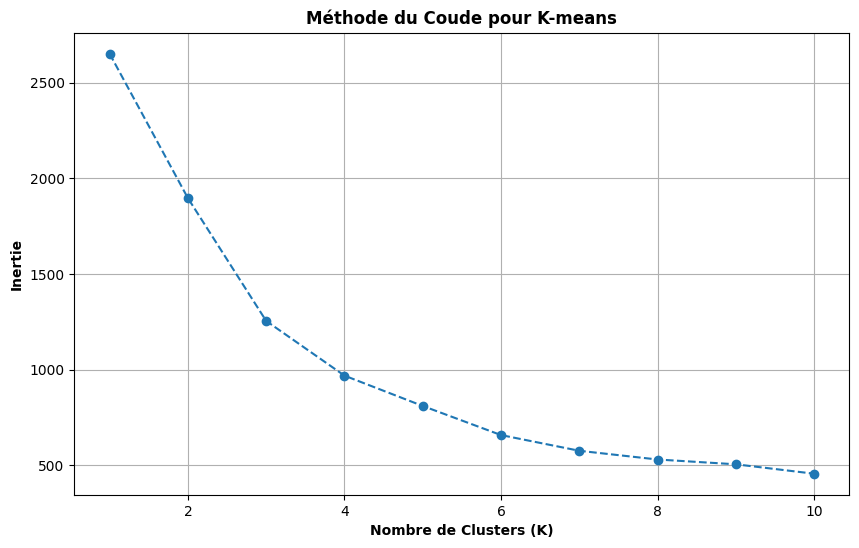

In [60]:
from sklearn.cluster import KMeans

# Calcul de l'inertie pour K=1 à K=10
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Tracé de la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel("Nombre de Clusters (K)", fontweight='bold')
plt.ylabel("Inertie", fontweight='bold')
plt.title("Méthode du Coude pour K-means", fontweight='bold')
plt.grid()
plt.show()

In [63]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_pca)

# Ajout des clusters au DataFrame
sample_df_clean['Cluster_Kmeans'] = clusters_kmeans

# Visualisation des Clusters

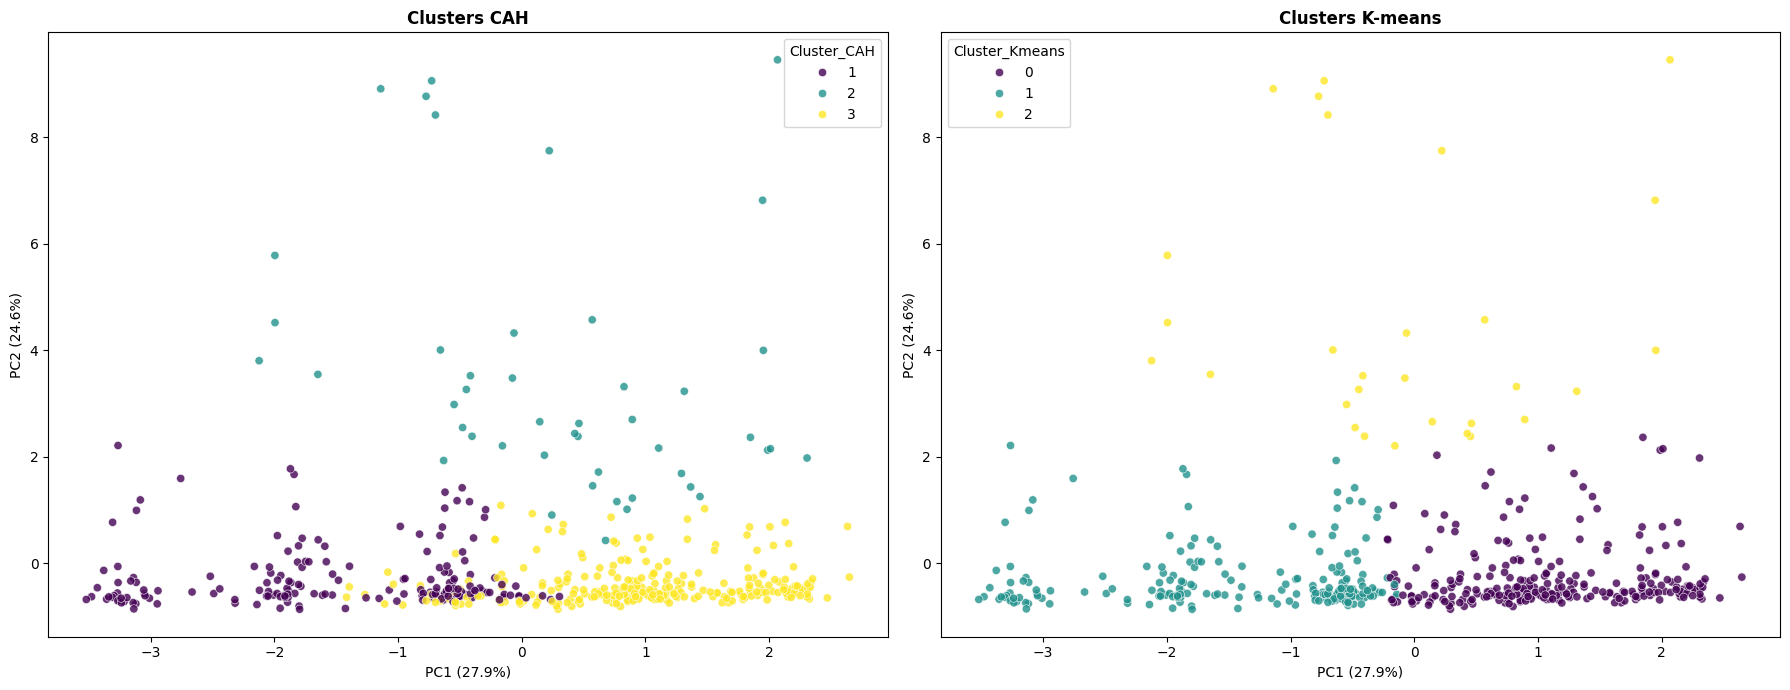

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# CAH
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=sample_df_clean['Cluster_CAH'],
    palette="viridis",
    alpha=0.8,
    ax=axes[0]
)
axes[0].set_title("Clusters CAH", fontweight='bold')
axes[0].set_xlabel("PC1 (27.9%)")
axes[0].set_ylabel("PC2 (24.6%)")

# K-means
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=sample_df_clean['Cluster_Kmeans'],
    palette="viridis",
    alpha=0.8,
    ax=axes[1]
)
axes[1].set_title("Clusters K-means", fontweight='bold')
axes[1].set_xlabel("PC1 (27.9%)")
axes[1].set_ylabel("PC2 (24.6%)")

plt.tight_layout()
plt.show()

<ipython-input-65-565e2363f4b8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sample_df_clean['Cluster_CAH'], palette="viridis", ax=axes[0])
<ipython-input-65-565e2363f4b8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sample_df_clean['Cluster_Kmeans'], palette="viridis", ax=axes[1])


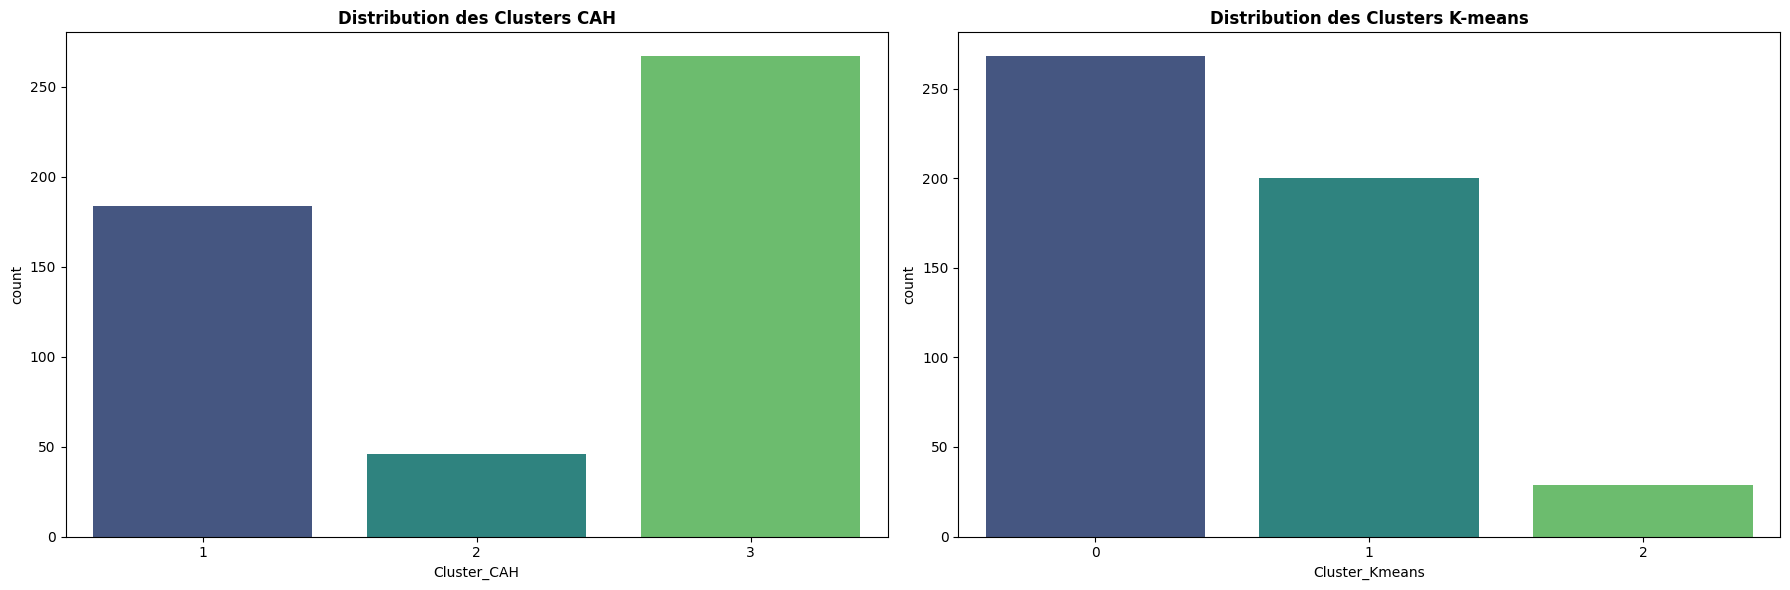

In [65]:
# Taille des clusters
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# CAH
sns.countplot(x=sample_df_clean['Cluster_CAH'], palette="viridis", ax=axes[0])
axes[0].set_title("Distribution des Clusters CAH", fontweight='bold')

# K-means
sns.countplot(x=sample_df_clean['Cluster_Kmeans'], palette="viridis", ax=axes[1])
axes[1].set_title("Distribution des Clusters K-means", fontweight='bold')

plt.tight_layout()
plt.show()

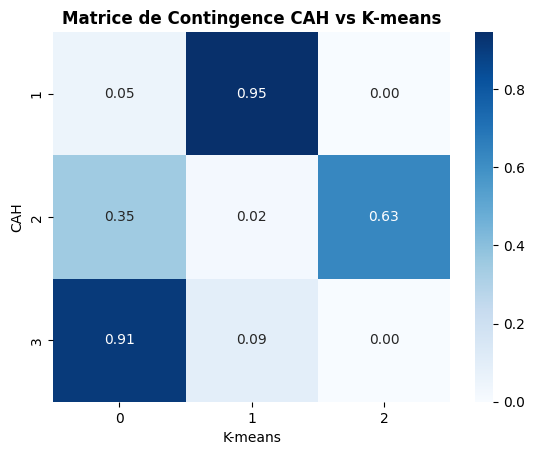

In [66]:
contingency_table = pd.crosstab(
    sample_df_clean['Cluster_CAH'],
    sample_df_clean['Cluster_Kmeans'],
    normalize='index'
)

sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de Contingence CAH vs K-means", fontweight='bold')
plt.xlabel("K-means")
plt.ylabel("CAH")
plt.show()

In [67]:
from sklearn.metrics import adjusted_rand_score

# Si vous avez une variable de segmentation réelle (ex. 'Customer Type')
ari_score = adjusted_rand_score(
    sample_df_clean['Customer Type'],
    sample_df_clean['Cluster_CAH']
)
print(f"Indice de Rand Ajusté (CAH vs Customer Type): {ari_score:.2f}")

ari_score = adjusted_rand_score(
    sample_df_clean['Customer Type'],
    sample_df_clean['Cluster_Kmeans']
)
print(f"Indice de Rand Ajusté (K-means vs Customer Type): {ari_score:.2f}")

Indice de Rand Ajusté (CAH vs Customer Type): 0.03
Indice de Rand Ajusté (K-means vs Customer Type): 0.01
